## LABORATORIO 1
### Exploración, preparación y regresión lineal 
En este laboratorio se realiza el análisis y preparación de un conjunto de datos clínicos para construir un modelo de regresión lineal que permita estimar el **CVD Risk Score** a partir de diferentes factores de riesgo.

#### Autores:
* Sergio Ferreira
* Juan David Gutierrez Rodriguez

---
## 1. Importación de las librerías

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

---
## 2. Carga de datos

In [2]:
data_cvd = pd.read_csv('data/Datos Lab 1.csv')

# Trabajamos con una copia de los datos
data = data_cvd.copy()

data.sample(3)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
1605,proD4199,07/09/2021,F,NaN,79.600,1.880,22.500,97.000,114/85,194.0,...,Moderate,N,188.00,0.516,114.0,85.0,Hypertension Stage 1,NaN,14.080,INTERMEDIARY
848,ZoSr4813,16/10/2020,M,31.0,99.921,1.588,21.277,105.875,121/115,287.0,...,High,Y,158.75,0.667,121.0,115.0,Hypertension Stage 2,NaN,16.045,INTERMEDIARY
397,QofN2517,05-02-2020,M,41.0,110.900,1.740,36.600,92.800,114/89,125.0,...,Low,N,174.00,0.533,114.0,89.0,Hypertension Stage 1,25.0,15.881,HIGH


---
## 3. Limpieza de datos


### Pacientes duplicados
Inicialmente vamos a verificar si existen pacientes duplicados y de existir guardar únicamente la entrada más reciente.

In [4]:
dup_counts = (data['Patient ID'].value_counts()
                        .loc[lambda s: s > 1]
                        .sort_values(ascending=False))
print("Pacientes duplicados:", len(dup_counts))
dup_counts

Pacientes duplicados: 171


Patient ID
oSqq7069    3
gBFe4249    3
AhYt1346    3
RlsB8509    3
RwGu5647    3
           ..
rKiV2789    2
ejaQ6145    2
ahGL8318    2
MgXe4245    2
pgnn4679    2
Name: count, Length: 171, dtype: int64

Observamos las filas asociadas para uno de los pacientes cuyo ID aparece más de una vez.

In [5]:
data[data['Patient ID']=="oSqq7069"]

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
10,oSqq7069,18 Jun 23,F,38.0,68.516,1.929,39.967,96.957,105/84,241.0,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,18.063,HIGH
430,oSqq7069,18 Jun 23,F,38.0,68.516,1.929,39.967,96.957,105/84,241.0,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,18.063,HIGH
1586,oSqq7069,18 Jun 23,F,38.0,68.516,1.929,39.967,96.957,105/84,241.0,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,33.384,HIGH


Para poder comparar las fechas de servicio en la columna *Date of Service* vamos a estandarizar las fechas, pues están con formatos mezclados, para esto utilizaremos la función `to_datetime` de la librería `pandas`

In [6]:
data['Date of Service'] = pd.to_datetime(data['Date of Service'], format='mixed')
data.sample(5)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
693,MFxu2651,2024-05-26,F,34.0,61.10,1.750,20.000,71.60,108/100,277.0,...,Moderate,N,175.000,0.409,108.0,100.0,Hypertension Stage 2,207.0,14.940,INTERMEDIARY
123,QgsB2968,2020-08-01,M,40.0,56.40,1.850,16.500,84.20,144/85,155.0,...,Moderate,Y,185.000,0.455,144.0,85.0,Hypertension Stage 1,72.0,13.600,LOW
1361,aTeR4129,2023-02-19,F,49.0,101.00,1.740,33.400,80.60,94/79,172.0,...,Moderate,Y,174.000,0.463,94.0,79.0,Normal,92.0,16.820,HIGH
1074,RCGk4053,2023-08-07,M,43.0,106.00,1.660,38.500,92.50,130/73,195.0,...,Moderate,N,166.000,0.557,130.0,73.0,Hypertension Stage 1,134.0,18.100,INTERMEDIARY
385,glVR1984,2022-10-26,M,79.0,84.51,1.684,19.546,97.86,157/65,115.0,...,Moderate,N,168.444,0.581,157.0,65.0,Hypertension Stage 2,22.0,14.059,INTERMEDIARY


Cómo se observa ahora todas las fechas mantienen el formato `YYYY-MM-DD`, así que podemos eliminar los registros duplicados de un paciente

In [7]:
data = data.sort_values(['Patient ID', 'Date of Service'], ascending=[True, False])
data = data.drop_duplicates(subset='Patient ID', keep='first')

# Observamos nuevamente el paciente que estaba duplicado.
data[data['Patient ID']=="oSqq7069"]

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
10,oSqq7069,2023-06-18,F,38.0,68.516,1.929,39.967,96.957,105/84,241.0,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,18.063,HIGH


### Codificación de variables categóricas

Ahora nos enfocaremos en convertir los descriptores con variables categóricas a variables numéricas, vital para la predicción basada en regresión, las variables a transformar son:

In [8]:
data.iloc[:, [2, 8, 12, 13, 14, 15, 20]].info()

<class 'pandas.DataFrame'>
Index: 1376 entries, 675 to 799
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Sex                      1376 non-null   str  
 1   Blood Pressure (mmHg)    1376 non-null   str  
 2   Smoking Status           1376 non-null   str  
 3   Diabetes Status          1376 non-null   str  
 4   Physical Activity Level  1376 non-null   str  
 5   Family History of CVD    1376 non-null   str  
 6   Blood Pressure Category  1376 non-null   str  
dtypes: str(7)
memory usage: 86.0 KB


En este punto transformaremos las variables: 
* *Sex*
* *Smoking Status* 
* *Diabetes Status*
* *Family History of CVD*

Estas pueden transformarse a variables binarias. Por convención tomaremos los valores `Y` y `F` (en el caso de *Sex*) como 1 y los valores `N` y `M` como 0. 

In [9]:
# Valores (NO, YES) como (0, 1)
encoder_NY = OrdinalEncoder(categories=[['N', 'Y']])

data['Smoking Status'] = encoder_NY.fit_transform(data[['Smoking Status']]).astype(int)
data['Diabetes Status'] = encoder_NY.fit_transform(data[['Diabetes Status']]).astype(int)
data['Family History of CVD'] = encoder_NY.fit_transform(data[['Family History of CVD']]).astype(int)

# Valores (MALE, FEMALE) como (0, 1)
encoder_MF = OrdinalEncoder(categories=[['M', 'F']])

data['Sex'] = encoder_MF.fit_transform(data[['Sex']]).astype(int)

Continuamos transformando las variables ordinales: 
* *Physical Activity Level*
* *Blood Pressure Category*
* *CVD Risk Level* 

Usaremos una codificación ordinal.

In [10]:
encoder_PAL = OrdinalEncoder(categories=[['Low', 'Moderate', 'High']])
data['Physical Activity Level'] = encoder_PAL.fit_transform(data[['Physical Activity Level']]).astype(int)

encoder_BPC = OrdinalEncoder(categories=[['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2']])
data['Blood Pressure Category'] = encoder_BPC.fit_transform(data[['Blood Pressure Category']]).astype(int)

Por último vamos a redondear la edad y el HDL al número entero más cercano para manejar una mejor escala.

In [11]:
data['Age'] = data['Age'].dropna().round().astype(int)

### Eliminación de variables redundantes

Finalmente, debemos codificar la variable *Blood Pressure* la cual está reportada con dos valores en columnas adicionales que separan estos valores en *Systolic BP* y *Diastolic BP*, por lo que esta columna no presenta información nueva y puede ser eliminada. 

Adicionalmente, existen otras columnas que pueden ser eliminadas ya que no tienen implicaciones con la variable a predecir, como *Date of Service* o *Patient ID* que son arbitrarias, o que no tienen sentido conocerla antes de realizar la predicción pues son dependientes de la variable a predecir, como *CVD Risk Level*.

In [12]:
data.drop(columns=['Patient ID', 'Date of Service', 'Blood Pressure (mmHg)', 'CVD Risk Level'], inplace=True)
data.info()

<class 'pandas.DataFrame'>
Index: 1376 entries, 675 to 799
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           1376 non-null   int64  
 1   Age                           1317 non-null   float64
 2   Weight (kg)                   1313 non-null   float64
 3   Height (m)                    1327 non-null   float64
 4   BMI                           1332 non-null   float64
 5   Abdominal Circumference (cm)  1327 non-null   float64
 6   Total Cholesterol (mg/dL)     1319 non-null   float64
 7   HDL (mg/dL)                   1310 non-null   float64
 8   Fasting Blood Sugar (mg/dL)   1329 non-null   float64
 9   Smoking Status                1376 non-null   int64  
 10  Diabetes Status               1376 non-null   int64  
 11  Physical Activity Level       1376 non-null   int64  
 12  Family History of CVD         1376 non-null   int64  
 13  Height (cm)       

Cómo podemos observar, tenemos todas nuestras variables como datos numéricos, necesario para el modelo de regresión lineal. A partir de ahora podemos analizar los datos de nuestras columnas y aplicar transformaciones numéricas para favorecer los resultados del modelo.

### Valores atípicos

Para el buen comportamiento del modelo de regresión es importante eliminar valores atípicos pues el error cuadrático medio usado para optimizar el modelo puede ser sensible a dichos valores. Para observar los valores atípicos seguiremos el criterio de estar 1.5 veces el tamaño del rango intercuartílico alejado de un cuartil extremo.

In [13]:
columns = data.columns.drop(['Sex', 'Smoking Status', 'Diabetes Status', 'Family History of CVD', 'Physical Activity Level', 'Blood Pressure Category'])
resultados = []

for columna in columns:
    datos = data[columna].dropna()

    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1

    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    n_outliers = ((datos < limite_inferior) | (datos > limite_superior)).sum()

    resultados.append({
        'variable': columna,
        'outliers': n_outliers
    })

outliers_df = pd.DataFrame(resultados)
outliers_df.sort_values(by='outliers', ascending=False)

,variable,outliers
13,CVD Risk Score,50
11,Diastolic BP,16
9,Waist-to-Height Ratio,13
7,Fasting Blood Sugar (mg/dL),13
0,Age,10
10,Systolic BP,9
3,BMI,7
12,Estimated LDL (mg/dL),7
8,Height (cm),4
2,Height (m),4


Inicialmente, eliminaremos los outliers existentes en *CVD Risk Score* puesto que al ser la variable a predecir, estos valores pueden sesgar altamente el modelo.

In [14]:
q1 = data['CVD Risk Score'].quantile(0.25)
q3 = data['CVD Risk Score'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

data = data[(data['CVD Risk Score'] > limite_inferior) & (data['CVD Risk Score'] < limite_superior)]


Para las demás columnas observaremos diagramas de puntos para observar la dispersión y valores atípicos.

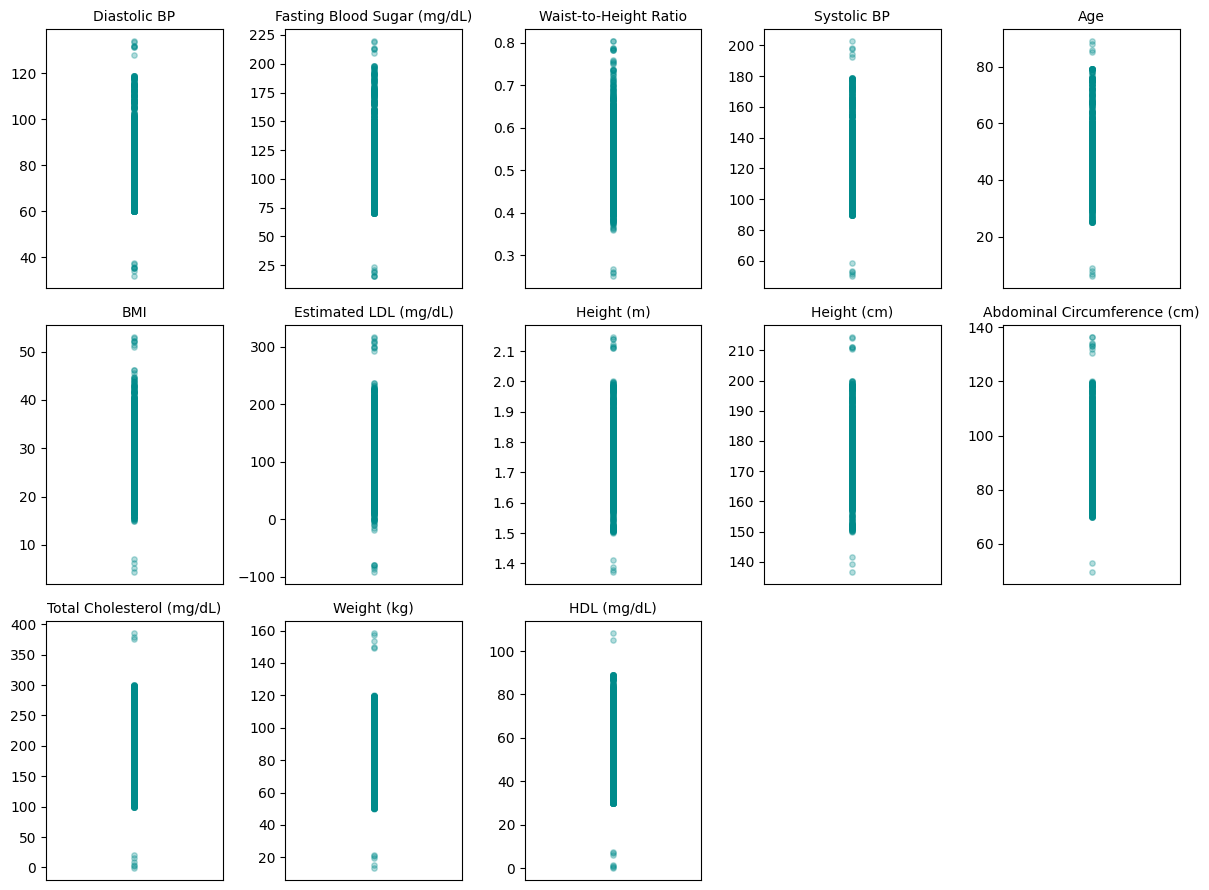

In [15]:
columnas = ['Diastolic BP', 'Fasting Blood Sugar (mg/dL)', 'Waist-to-Height Ratio', 'Systolic BP', 'Age', 'BMI', 'Estimated LDL (mg/dL)',
            'Height (m)', 'Height (cm)', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'Weight (kg)', 'HDL (mg/dL)']
fig, axes = plt.subplots(3, 5, figsize=(12, 9))
axes = axes.flatten()

for i, columna in enumerate(columnas):
    datos = data[columna].dropna()

    x = np.zeros_like(datos)
    
    axes[i].scatter(x, datos, alpha=0.3, s=15, color='darkcyan')
    
    axes[i].set_title(columna, fontsize=10)
    axes[i].set_xticks([])
    axes[i].set_xlim(-0.2, 0.2)
for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Según los resultados de las gráficas se observan grupos de valores atípicos lejanos de la distribución de los datos, estos valores inviables tienen efectos negativos en un modelo de regresión. Por ejemplo podemos ver que los pesos menores a 30 kg son imposibles para personas adultas de más de 170 cm de estatura, pesos de más de 140kg imposibles para BMI menores a 40, alturas en centimetros que no corresponden a la medición en metros o edades menores a 10 años imposibles para personas de más de 60 kg de peso.

In [16]:
data[data['Weight (kg)'] < 30]

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
1317,0,38.0,21.038,1.820,22.600,NaN,165.0,56.0,137.0,1,0,1,1,182.000,0.541,113.0,94.0,3,79.0,13.470
291,1,37.0,15.036,1.870,25.900,87.600,252.0,79.0,133.0,1,1,2,1,187.000,0.468,113.0,75.0,0,143.0,17.870
1041,1,68.0,19.578,1.995,29.507,103.497,134.0,45.0,175.0,1,0,0,0,199.548,0.519,128.0,88.0,2,59.0,14.981
1579,0,40.0,21.316,1.900,24.300,NaN,216.0,61.0,146.0,0,0,2,0,190.000,0.380,90.0,72.0,0,125.0,13.680
1233,1,56.0,13.261,1.730,33.400,93.800,208.0,61.0,79.0,0,0,1,0,173.000,0.542,145.0,79.0,3,117.0,18.090


In [17]:
data[data['Weight (kg)'] > 140]


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
1257,1,41.0,158.523,1.700,22.500,75.200,190.0,33.0,90.0,1,1,0,1,170.000,0.442,139.0,60.0,2,127.0,17.250
223,1,60.0,153.556,1.620,NaN,87.200,174.0,71.0,94.0,0,1,0,0,162.000,0.538,141.0,70.0,3,73.0,17.890
1366,1,32.0,157.164,1.898,36.837,72.410,233.0,52.0,84.0,0,0,2,1,189.815,0.381,125.0,NaN,3,151.0,18.277
586,1,35.0,149.335,1.780,NaN,119.672,173.0,60.0,187.0,0,1,2,1,177.996,0.672,113.0,65.0,0,83.0,18.323
646,1,45.0,149.877,1.616,39.633,109.352,256.0,75.0,160.0,0,1,2,1,161.584,0.677,175.0,98.0,3,151.0,23.797


In [18]:
data[data['Age'] < 10]


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
45,0,6.0,69.769,1.696,22.060,74.184,197.0,65.0,151.0,1,0,0,0,169.560,0.438,120.0,76.0,1,NaN,14.352
331,0,9.0,87.055,1.527,23.245,96.493,132.0,80.0,188.0,1,0,0,0,152.679,0.632,103.0,72.0,0,22.0,12.439
1553,0,7.0,98.700,1.630,37.100,89.700,158.0,64.0,131.0,1,1,1,1,163.000,0.550,139.0,93.0,2,64.0,19.530
1172,1,8.0,112.520,1.520,21.988,106.120,228.0,40.0,91.0,0,1,0,1,152.020,0.698,117.0,96.0,3,158.0,16.808


In [19]:
data[data['Height (cm)'] > 200]

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
130,0,33.0,118.300,1.690,41.400,72.10,171.0,44.0,145.0,0,0,1,0,210.554,0.427,116.0,93.0,3,97.0,17.500
1604,1,58.0,69.000,1.870,19.700,77.50,184.0,45.0,75.0,0,1,0,1,210.981,0.414,107.0,88.0,2,109.0,14.970
1084,0,55.0,88.834,1.665,27.856,91.37,106.0,NaN,87.0,1,0,0,0,210.624,NaN,120.0,75.0,1,39.0,13.691
608,1,46.0,88.100,1.630,33.200,98.70,166.0,78.0,103.0,1,1,0,1,213.920,0.606,95.0,81.0,2,58.0,16.710
433,1,57.0,100.800,1.840,29.800,88.40,102.0,33.0,128.0,1,1,2,0,214.394,0.480,110.0,78.0,0,39.0,15.500
1277,0,37.0,78.100,1.850,22.800,74.20,118.0,70.0,72.0,0,1,1,0,211.127,0.401,100.0,76.0,0,18.0,13.920


Por esta razón establecemos rangos razonables para los datos reemplazando los valores atípicos por fuera de estos rangos por `NaN` para aplicar estrategias de imputación posteriormente.

In [20]:
rangos = {
    'Diastolic BP': (40, 125),
    'Systolic BP': (80, 190),
    'Fasting Blood Sugar (mg/dL)': (60, 200),
    'Total Cholesterol (mg/dL)': (80, 320),
    'HDL (mg/dL)': (20, 100),
    'Estimated LDL (mg/dL)': (0, 250),
    'BMI': (15, 50),
    'Weight (kg)': (30, 140),
    'Height (m)': (1.45, 2),
    'Height (cm)': (145, 200),
    'Abdominal Circumference (cm)': (60, 130),
    'Waist-to-Height Ratio': (0.35, 0.8),
    'Age': (18, 100)
}
for col, (min_val, max_val) in rangos.items():
    if col in data.columns:
        data.loc[
            (data[col] <= min_val) | (data[col] >= max_val),
            col
        ] = np.nan
data.describe()

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
count,1298.000000,1236.000000,1227.000000,1241.000000,1243.000000,1243.000000,1234.000000,1224.000000,1240.000000,1298.000000,1298.000000,1298.000000,1298.000000,1233.000000,1230.000000,1235.000000,1228.000000,1298.000000,1227.000000,1298.000000
mean,0.503852,47.262136,86.198337,1.755085,28.557304,91.758523,198.984603,56.253268,117.066935,0.510015,0.501541,1.020031,0.489985,175.518969,0.525837,125.824291,82.981270,1.966102,112.840261,16.967587
std,0.500178,12.648313,20.980157,0.113150,7.056570,12.839031,57.519408,16.136009,30.459084,0.500092,0.500190,0.816880,0.500092,11.309207,0.083041,22.105700,14.819714,1.119157,57.653778,2.499918
min,0.000000,25.000000,50.100000,1.502000,15.100000,70.000000,100.000000,30.000000,70.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.360000,90.000000,60.000000,0.000000,1.000000,10.530000
25%,0.000000,37.000000,67.350000,1.668000,22.680500,80.544500,151.000000,42.000000,92.000000,0.000000,0.000000,0.000000,0.000000,166.984000,0.458250,108.000000,71.000000,1.000000,63.000000,15.170000
50%,1.000000,47.000000,87.400000,1.760000,28.300000,91.500000,197.000000,56.000000,115.000000,1.000000,1.000000,1.000000,0.000000,176.000000,0.522000,125.000000,82.000000,2.000000,111.000000,16.899000
75%,1.000000,56.000000,105.050000,1.846000,34.152000,102.286000,250.000000,70.000000,138.000000,1.000000,1.000000,2.000000,1.000000,184.449000,0.583750,141.000000,94.000000,3.000000,159.000000,18.671250
max,1.000000,89.000000,120.000000,1.998000,46.200000,119.996000,300.000000,89.000000,198.000000,1.000000,1.000000,2.000000,1.000000,199.960000,0.787000,179.000000,119.000000,3.000000,237.000000,24.170000


---
## Transformación de los datos

### Completitud e Imputación
Ahora debe observarse el nivel de completitud de las columnas restantes y en base a esto decidir la estrategia de imputación sobre los datos faltantes.

Inicialmente vamos a eliminar las entradas que tengan datos faltantes en *CVD Risk Score* la cual es nuestra variable a predecir.

In [21]:
print("CVD Risk Score faltantes: ", data['CVD Risk Score'].isnull().sum())
data = data.dropna(subset=['CVD Risk Score'])

CVD Risk Score faltantes:  0


In [22]:
((data.isnull().sum()/data.shape[0])).sort_values(ascending=False)

HDL (mg/dL)                     0.057011
Weight (kg)                     0.054700
Estimated LDL (mg/dL)           0.054700
Diastolic BP                    0.053929
Waist-to-Height Ratio           0.052388
Height (cm)                     0.050077
Total Cholesterol (mg/dL)       0.049307
Systolic BP                     0.048536
Age                             0.047766
Fasting Blood Sugar (mg/dL)     0.044684
Height (m)                      0.043914
Abdominal Circumference (cm)    0.042373
BMI                             0.042373
Sex                             0.000000
Smoking Status                  0.000000
Diabetes Status                 0.000000
Physical Activity Level         0.000000
Family History of CVD           0.000000
Blood Pressure Category         0.000000
CVD Risk Score                  0.000000
dtype: float64

Cómo se puede observar todas las variables tienen un nivel de completitud de al menos 94%, por lo que no es conveniente eliminar descriptores y se prefiere aplicar estrategias de imputación.
Para cada una de las variables faltantes se buscan variables correlacionadas que puedan ayudar a predecir los valores faltantes, para esto se realiza una matriz de correlación.

<Axes: >

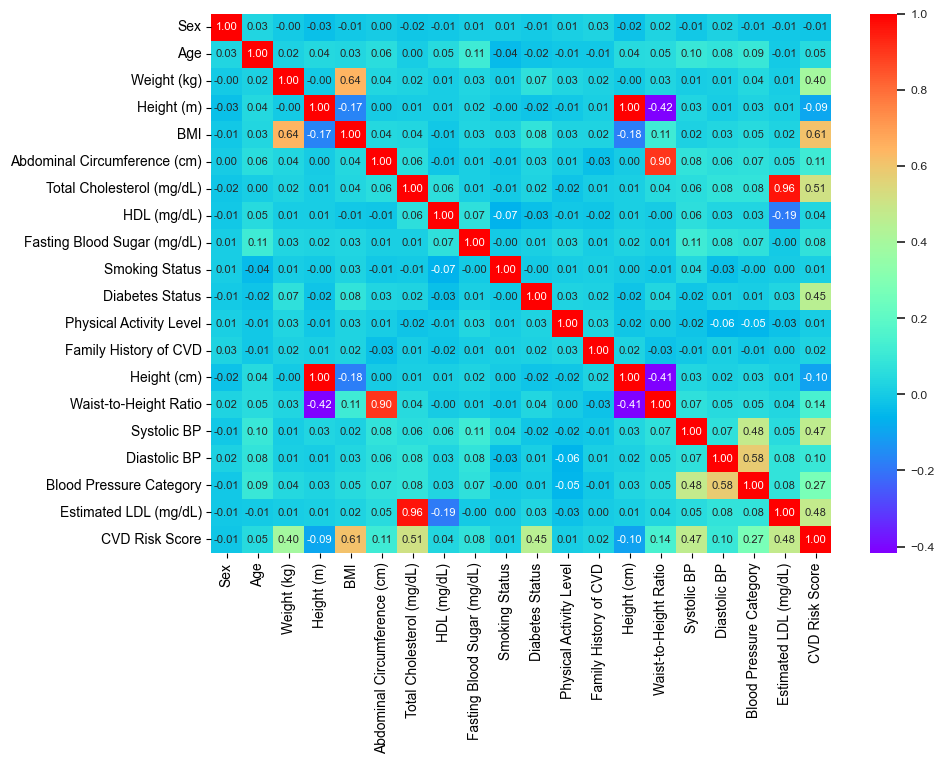

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_theme(font_scale=0.8)
sns.heatmap(data.corr(), ax=ax, cmap='rainbow', annot=True, fmt='.2f', annot_kws={"size": 8})

Con respecto a las variables con valores faltantes se pueden establecer las siguientes relaciones de colinealidad:
* *Waist-to-Height Ratio* <--> *Abdominal Circumference*
* *Total Cholesterol* <--> *Estimated LDL*
* *Height (cm)* <--> *Height (m)*

Las demás variables deben ser imputadas independientemente, para esto observaremos la distribución de cada una de ellas.

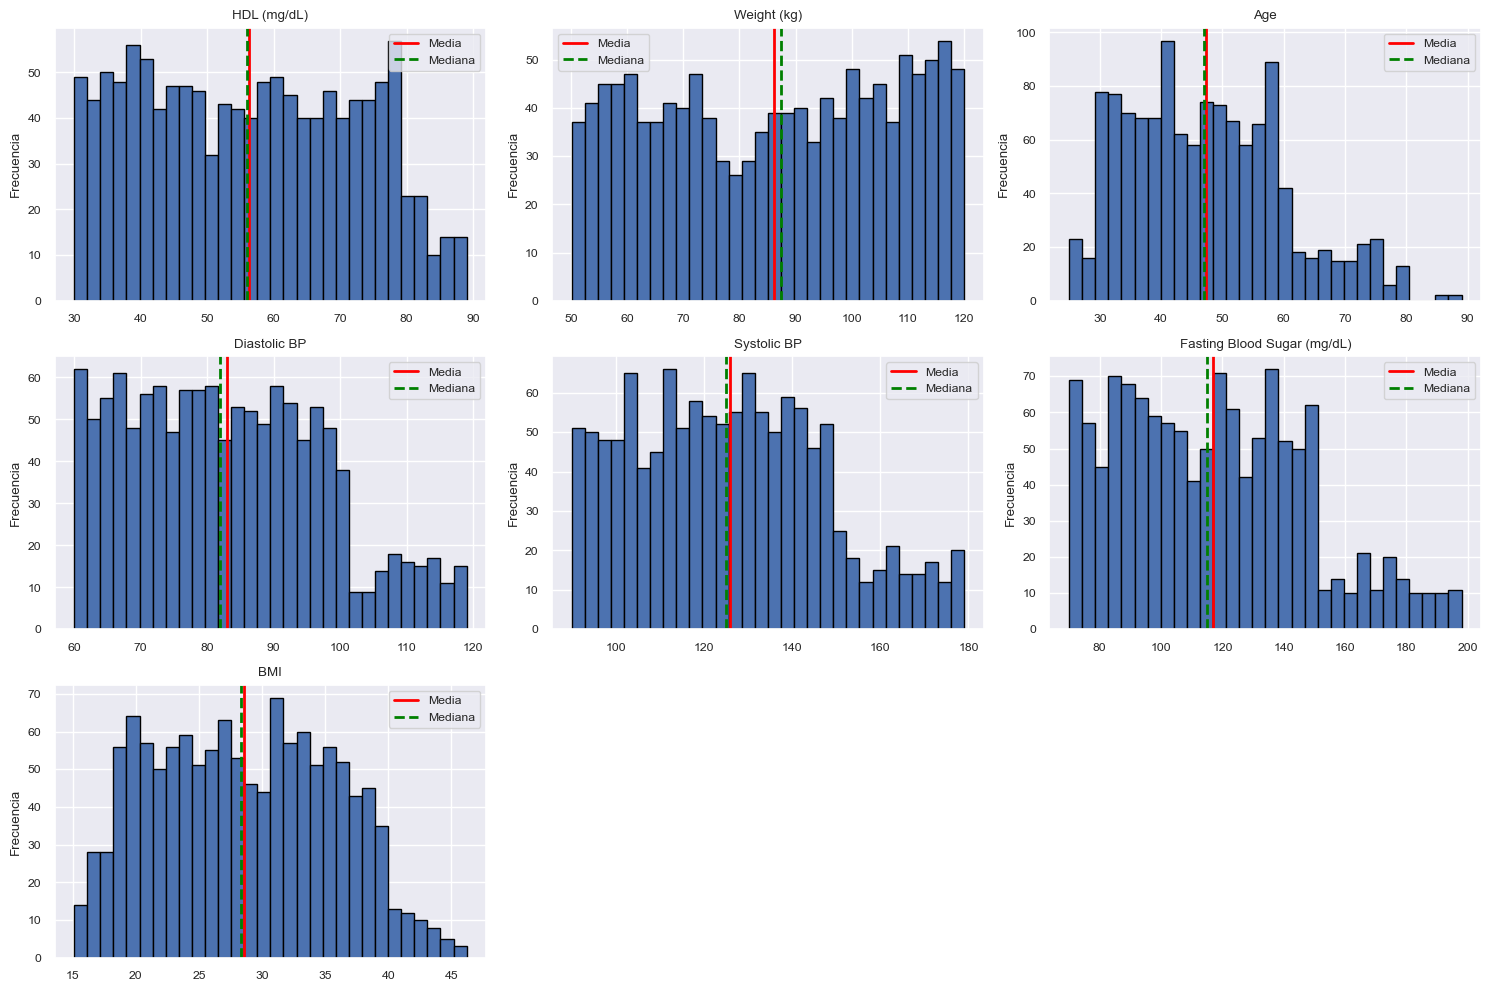

In [24]:
columnas = ['HDL (mg/dL)', 'Weight (kg)', 'Age', 'Diastolic BP', 'Systolic BP', 'Fasting Blood Sugar (mg/dL)', 'BMI']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, columna in enumerate(columnas):
    datos = data[columna].dropna()
    axes[i].hist(
        datos,
        bins=30,
        edgecolor='black'
    )
    media = datos.mean()
    mediana = datos.median()
    axes[i].axvline(
        media,
        linestyle='-',
        linewidth=2,
        label='Media',
        color='red'
    )
    axes[i].axvline(
        mediana,
        linestyle='--',
        linewidth=2,
        label='Mediana',
        color='green'
    )
    axes[i].set_title(columna)
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()

for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Dado que en todas las distribuciones se observa una tendencia hacia la media y mediana y dado que estas dos medidas se encuentran muy cercanas entre sí entre todas las distribuciones, se decidió imputar por la mediana a las variables enteras (*Age*, *Diastolic BP*, *Systolic BP*, *HDL* y *Fasting Blood Sugar*) y por la media a las variables flotantes (*Weight* y *BMI*).

In [25]:
median_columns = ['Age', 'Diastolic BP', 'Systolic BP', 'Fasting Blood Sugar (mg/dL)', 'HDL (mg/dL)']
mean_columns = ['Weight (kg)', 'BMI']

data[median_columns] = data[median_columns].fillna(data[median_columns].median())
data[mean_columns] = data[mean_columns].fillna(data[mean_columns].mean())

Después de la imputación simple de estas variables independientes podemos imputar por regresión a las variables correlacionadas mencionadas anteriormente.

In [26]:
# Waist to height ratio
temp_abdominal = data['Abdominal Circumference (cm)'].fillna(data['Abdominal Circumference (cm)'].mean())
k = (data['Waist-to-Height Ratio'] / temp_abdominal).dropna().median()
data['Waist-to-Height Ratio'] = data['Waist-to-Height Ratio'].fillna(k * temp_abdominal)

# Abdominal circumference
k = (data['Abdominal Circumference (cm)'] / data['Waist-to-Height Ratio']).dropna().median()
data['Abdominal Circumference (cm)'] = data['Abdominal Circumference (cm)'].fillna(k * data['Waist-to-Height Ratio'])

# Total cholesterol
temp_ldl = data['Estimated LDL (mg/dL)'].fillna(data['Estimated LDL (mg/dL)'].median())
k = (data['Total Cholesterol (mg/dL)'] / temp_ldl).dropna().median()
data['Total Cholesterol (mg/dL)'] = data['Total Cholesterol (mg/dL)'].fillna(k * temp_ldl)

# Estimated LDL
k = (data['Estimated LDL (mg/dL)'] / data['Total Cholesterol (mg/dL)']).dropna().median()
data['Estimated LDL (mg/dL)'] = data['Estimated LDL (mg/dL)'].fillna(k * data['Total Cholesterol (mg/dL)'])

# Height (cm)
temp_height_m = data['Height (m)'].fillna(data['Height (m)'].median())
data['Height (cm)'] = data['Height (cm)'].fillna(temp_height_m * 100)

#height (m)
data['Height (m)'] = data['Height (m)'].fillna(data['Height (cm)'] / 100)

Con esto completamos el proceso de imputación y observamos que no existen más valores faltantes.

In [27]:
((data.isnull().sum()/data.shape[0])).sort_values(ascending=False)

Sex                             0.0
Age                             0.0
Weight (kg)                     0.0
Height (m)                      0.0
BMI                             0.0
Abdominal Circumference (cm)    0.0
Total Cholesterol (mg/dL)       0.0
HDL (mg/dL)                     0.0
Fasting Blood Sugar (mg/dL)     0.0
Smoking Status                  0.0
Diabetes Status                 0.0
Physical Activity Level         0.0
Family History of CVD           0.0
Height (cm)                     0.0
Waist-to-Height Ratio           0.0
Systolic BP                     0.0
Diastolic BP                    0.0
Blood Pressure Category         0.0
Estimated LDL (mg/dL)           0.0
CVD Risk Score                  0.0
dtype: float64

### Escalado de los datos

Seleccionamos las columnas que tenga sentido normalizar.

In [28]:
cols = ["Age", "Weight (kg)", "Height (m)", "BMI", "Abdominal Circumference (cm)", "Total Cholesterol (mg/dL)", "HDL (mg/dL)", "Fasting Blood Sugar (mg/dL)", "Systolic BP", "Diastolic BP"]

data[cols].head()

,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Systolic BP,Diastolic BP
675,52.0,109.700000,1.780,34.600,104.400,197.000000,56.0,99.0,103.0,99.0
1369,47.0,104.469000,1.995,25.390,86.894,260.908446,82.0,175.0,164.0,90.0
774,58.0,86.198337,1.870,33.800,99.600,106.000000,56.0,115.0,125.0,91.0
1044,52.0,107.800000,1.780,34.000,103.500,179.000000,73.0,132.0,111.0,69.0
1290,57.0,116.772000,1.569,34.126,90.737,254.000000,60.0,177.0,117.0,116.0


Ahora pasamos a normalizar los valores. Para esto se usara la herramienta `MinMaxScaler` de la librería `Scikit-Learn`.

In [29]:
# Usamos una copia del datset para transformarlo.
datatransf = data.copy()

# Normalización
scaler = MinMaxScaler()
datatransf[cols] = scaler.fit_transform(datatransf[cols])

# Observar normalización
datatransf[cols].head()

,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Systolic BP,Diastolic BP
675,0.421875,0.852647,0.560448,0.627010,0.637475,0.465084,0.440678,0.226562,0.146067,0.661017
1369,0.343750,0.777811,0.990793,0.330868,0.345689,0.632558,0.881356,0.820312,0.831461,0.508475
774,0.515625,0.516428,0.740592,0.601286,0.557469,0.226614,0.440678,0.351562,0.393258,0.525424
1044,0.421875,0.825465,0.560448,0.607717,0.622474,0.417914,0.728814,0.484375,0.235955,0.152542
1290,0.500000,0.953820,0.138110,0.611768,0.409743,0.614454,0.508475,0.835938,0.303371,0.949153


### Multicolinealidad

Después del proceso de imputación graficaremos de nuevo la matriz de correlación de los datos, en esta matriz será importante observar las columnas que brinden información redundante o no correlacionada con la columna objetivo, *CVD Risk Score*.

<Axes: >

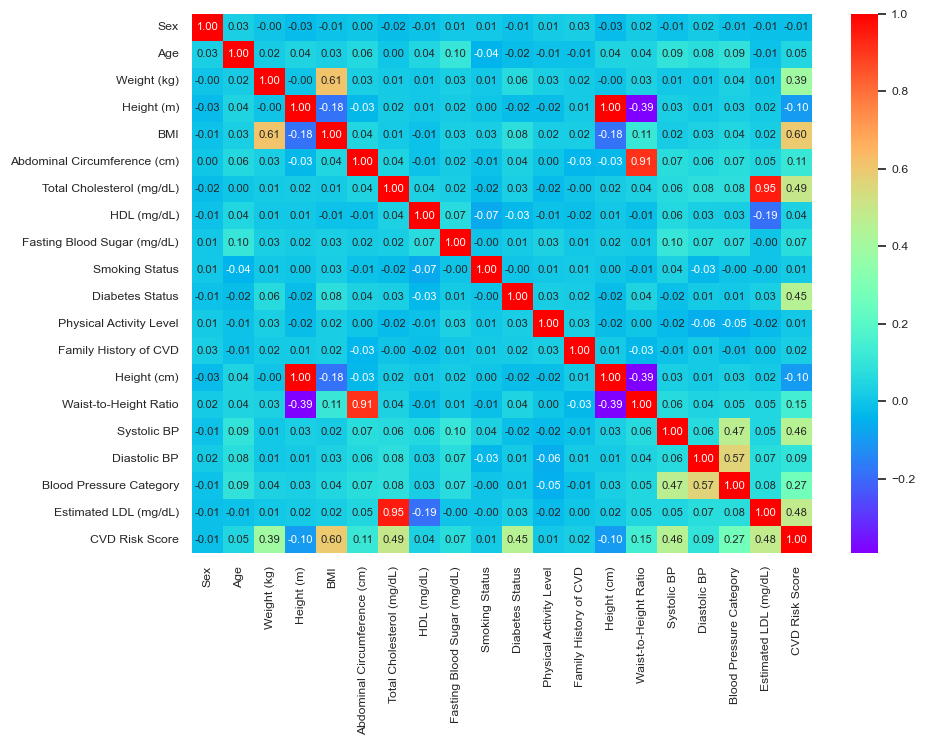

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_theme(font_scale=0.8)
sns.heatmap(datatransf.corr(), ax=ax, cmap='rainbow', annot=True, fmt='.2f', annot_kws={"size": 8})

A partir de los datos observados podemos afirmar que existen variables con alta multicolinealidad por lo que pueden estar brindando información redundante que puede llegar a confundir al modelo. Por lo tanto se deciden eliminar las variables *Height (cm)*, *Waist-to-Height Ratio* y *Estimated LDL*. 

Además se puede observar una correlación moderada de *Blood Pressure Category* con *Systolic BP* y *Diastolic BP*, sin embargo decidimos eliminar la columna *Blood Pressure Category* puesto que depende directamente de las otras dos columnas y que el no tener un nivel alto de colinealidad se explica por la separación de la variable en rangos.

In [31]:
datatransf.drop(columns=['Height (cm)', 'Waist-to-Height Ratio', 'Estimated LDL (mg/dL)', 'Blood Pressure Category'], inplace=True)
datatransf.sample(5)

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Systolic BP,Diastolic BP,CVD Risk Score
687,1,0.828125,0.880215,0.734588,0.222412,0.525667,0.520115,0.644068,0.750000,0,0,2,0,0.494382,0.118644,15.463
714,1,0.343750,0.337625,0.400320,0.334405,0.300786,0.451981,0.745763,0.578125,1,1,1,1,0.438202,0.542373,17.390
56,0,0.328125,0.313305,0.500400,0.270096,0.382458,0.467704,0.779661,0.554688,0,0,0,0,0.112360,0.508475,13.660
155,0,0.343750,0.934192,0.540432,0.697749,0.429128,0.260465,0.152542,0.375000,1,1,2,0,0.584270,0.067797,19.180
66,1,0.031250,0.930529,0.054043,0.314373,0.889074,0.601352,0.881356,0.835938,0,1,0,0,0.640449,0.508475,19.305


En cuanto a la correlación de las variables con la columna a predecir, se observa que las variables *Sex*, *Smoking Status*, *Physical Activity Level* y *Family History of CVD* tienen una baja correlación con *CVD Risk Score*, sin embargo son variables que a priori tienen un efecto sobre el riesgo de enfermedades cardiovasculares; por lo tanto se tomó la decisión de construir dos modelos, el primero con todas las variables que se tienen hasta el momento y el segundo eliminando estas variables que no muestran correlación con la variable a predecir.

In [32]:
# Datos para la construccion del primer modelo
data_model1 = datatransf.copy()

# Datos para la construccion del segundo modelo
data_model2 = datatransf.copy()
data_model2 = data_model2.drop(columns=['Sex', 'Smoking Status', 'Physical Activity Level', 'Family History of CVD'])

---
## 4. Construcción de modelos

### Partición de los datos
Separamos los datos en dos conjuntos: entrenamiento (**train**) y prueba (**test**). Se define también que la variable dependiente es el `CVD Risk Score`, y el resto de las variables se consideran como variables predictoras.

In [33]:
target = "CVD Risk Score"

# Modelo 1
model1_X = data_model1.drop(columns=[target])
model1_y = data_model1[target]

# Modelo 2
model2_X = data_model2.drop(columns=[target])
model2_y = data_model2[target]

Utilizaremos el 80 % de los datos para entrenar el modelo y el 20 % restante para evaluarlo.

In [34]:
# Modelo 1
model1_X_train, model1_X_test, model1_y_train, model1_y_test = train_test_split( 
    model1_X, 
    model1_y, 
    test_size=0.2, 
    random_state=1
)

# Modelo 2
model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split( 
    model2_X, 
    model2_y, 
    test_size=0.2, 
    random_state=1
)

### Entrenamiento del modelo de regresión lineal 1
Ahora, pasamos a entrenar el modelo con el conjunto de entrenamiento.

In [35]:
Modelo1 = LinearRegression()

Modelo1.fit(model1_X_train, model1_y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [36]:
model1_y_train_pred = Modelo1.predict(model1_X_train)

### Validación del modelo 1

**Mean Absolute Error (MAE)**

In [37]:
model1_mae_train = mean_absolute_error(model1_y_train, model1_y_train_pred)
print("MAE  train:", model1_mae_train)

MAE  train: 0.25207352449993714


**Root Mean Squeared Error (RMSE)**

In [38]:
model1_mse_train = mean_squared_error(model1_y_train, model1_y_train_pred)
model1_rmse_train = np.sqrt(model1_mse_train)
print("RMSE train:", model1_rmse_train)

RMSE train: 0.6430661413627338


**Coeficiente de  determinación R^2**

In [39]:
model1_r2_train = r2_score(model1_y_train, model1_y_train_pred)
print("R²   train:", model1_r2_train)

R²   train: 0.9333860410977631


### Comportamiento del modelo 1 con datos nuevos
Ahora, utilizamos el modelo para predecir sobre el conjunto de prueba (test).

In [40]:
model1_y_test_pred = Modelo1.predict(model1_X_test)

**Mean Absolute Error (MAE)**

In [41]:
model1_mae_test = mean_absolute_error(model1_y_test, model1_y_test_pred)
print("MAE  test:", model1_mae_test)

MAE  test: 0.310204199868674


**Root Mean Squeared Error (RMSE)**

In [42]:
model1_mse_test = mean_squared_error(model1_y_test, model1_y_test_pred)
model1_rmse_test = np.sqrt(model1_mse_test)
print("RMSE test:", model1_rmse_test)

RMSE test: 0.810591932169484


**Coeficiente de  determinación R^2**

In [43]:
model1_r2_test = r2_score(model1_y_test, model1_y_test_pred)
print("R² test:", model1_r2_test)

R² test: 0.8968075712618977
